### Logistic Regression Task
- 기계 센서 데이터를 통해 고장 여부를 예측하는 분류기를 모델화한다.

In [75]:
import pandas as pd

m_df = pd.read_csv('./datasets/machine.csv')
m_df

,Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,Machine failure
0,1551,42.8,0,0,0,0,0,0
1,1408,46.3,3,0,0,0,0,0
2,1498,49.4,5,0,0,0,0,0
3,1433,39.5,7,0,0,0,0,0
4,1408,40.0,9,0,0,0,0,0
...,...,...,...,...,...,...,...,...
9810,1604,29.5,14,0,0,0,0,0
9811,1632,31.8,17,0,0,0,0,0
9812,1645,33.4,22,0,0,0,0,0
9813,1408,48.5,25,0,0,0,0,0


In [76]:
m_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9815 entries, 0 to 9814
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Rotational speed [rpm]  9815 non-null   int64  
 1   Torque [Nm]             9815 non-null   float64
 2   Tool wear [min]         9815 non-null   int64  
 3   TWF                     9815 non-null   int64  
 4   HDF                     9815 non-null   int64  
 5   PWF                     9815 non-null   int64  
 6   OSF                     9815 non-null   int64  
 7   Machine failure         9815 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 613.6 KB


In [77]:
m_df.isna().sum()

Rotational speed [rpm]    0
Torque [Nm]               0
Tool wear [min]           0
TWF                       0
HDF                       0
PWF                       0
OSF                       0
Machine failure           0
dtype: int64

In [78]:
m_df.duplicated().sum()

6

In [79]:
m_df = m_df.drop_duplicates()

In [80]:
m_df.reset_index(drop=True, inplace=True)

In [81]:
m_df

,Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,Machine failure
0,1551,42.8,0,0,0,0,0,0
1,1408,46.3,3,0,0,0,0,0
2,1498,49.4,5,0,0,0,0,0
3,1433,39.5,7,0,0,0,0,0
4,1408,40.0,9,0,0,0,0,0
...,...,...,...,...,...,...,...,...
9804,1634,27.9,12,0,0,0,0,0
9805,1604,29.5,14,0,0,0,0,0
9806,1632,31.8,17,0,0,0,0,0
9807,1645,33.4,22,0,0,0,0,0


array([[<Axes: title={'center': 'Rotational speed [rpm]'}>,
        <Axes: title={'center': 'Torque [Nm]'}>,
        <Axes: title={'center': 'Tool wear [min]'}>],
       [<Axes: title={'center': 'TWF'}>, <Axes: title={'center': 'HDF'}>,
        <Axes: title={'center': 'PWF'}>],
       [<Axes: title={'center': 'OSF'}>,
        <Axes: title={'center': 'Machine failure'}>, <Axes: >]],
      dtype=object)

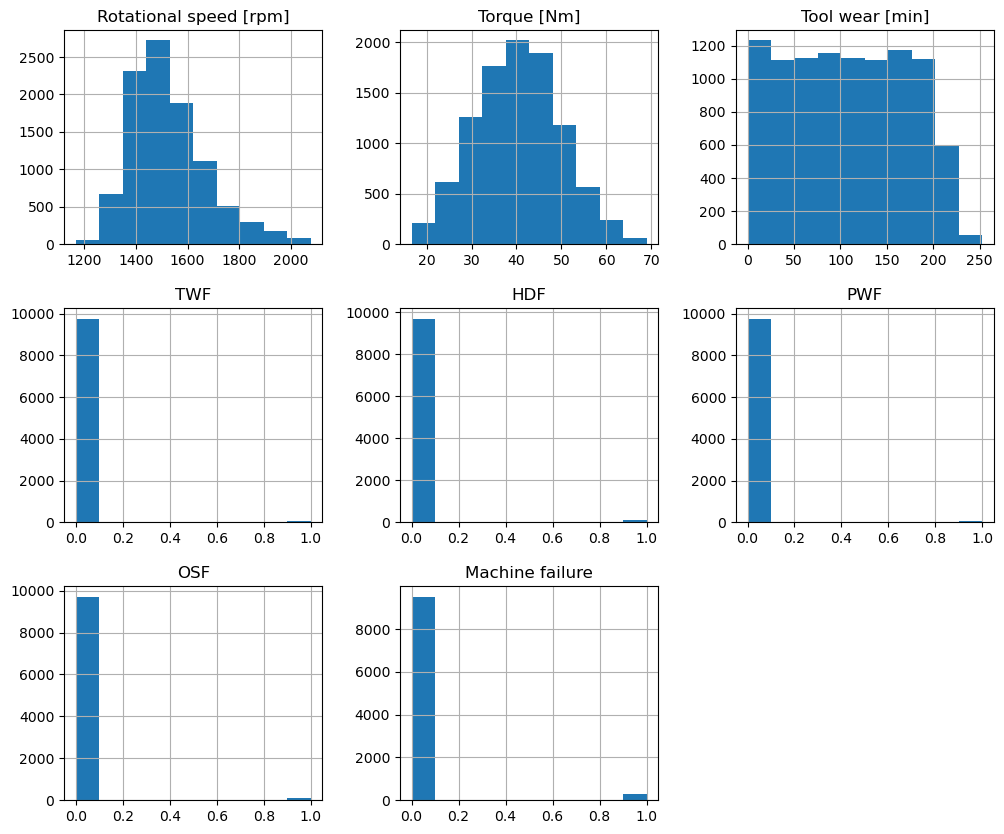

In [82]:
m_df.hist(figsize=(12,10))

In [83]:
m_df['Machine failure'].value_counts()

Machine failure
0    9523
1     286
Name: count, dtype: int64

In [84]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

features, targets = m_df.iloc[:, :-1], m_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, stratify=targets, test_size=0.2, random_state=124)

smote = SMOTE(random_state=124)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [85]:
y_train_over.value_counts()

Machine failure
0    7618
1    7618
Name: count, dtype: int64

In [86]:
import numpy as np
import torch
from torch.nn import Sequential, Linear, Sigmoid
from torch.nn.functional import binary_cross_entropy
from torch.optim import SGD
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

torch.manual_seed(124)

features, targets = m_df.iloc[:, :-1], m_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, stratify=targets, test_size=0.2, random_state=124)

smote = SMOTE(random_state=124)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

X_train = torch.FloatTensor(X_train_over.values)
y_train = torch.FloatTensor(y_train_over.values).view(-1, 1)
X_test = torch.FloatTensor(X_test.values)
y_test = torch.FloatTensor(y_test.values).view(-1, 1)

logistic_r = Sequential(
    Linear(7, 1),
    Sigmoid(),
)

optimizer = SGD(logistic_r.parameters(), lr=0.0001)

epochs = 100000

for epoch in range(1, epochs + 1):
    H = logistic_r(X_train)
    loss = binary_cross_entropy(H, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10000 == 0:
        print(f'Epoch: {epoch}/{epochs}')
        for i, w in enumerate(list(logistic_r.parameters())[0][0]):
            print(f'W{i + 1}: {np.round(w.item(), 4)}', end=', ')
        print(f'b: {np.round(list(logistic_r.parameters())[1][0].item(), 4)}')
        print(f'\nLoss: {np.round(loss.item(), 4)}')
        print('=' * 90)
    

Epoch: 10000/100000
W1: -0.2626, W2: 0.0991, W3: 0.2575, W4: -0.0196, W5: 0.0093, W6: -0.2849, W7: -0.1438, b: -0.0253

Loss: 50.0
Epoch: 20000/100000
W1: -0.2626, W2: 0.0991, W3: 0.2575, W4: -0.0196, W5: 0.0093, W6: -0.2849, W7: -0.1438, b: -0.0253

Loss: 50.0
Epoch: 30000/100000
W1: -0.2626, W2: 0.0991, W3: 0.2575, W4: -0.0196, W5: 0.0093, W6: -0.2849, W7: -0.1438, b: -0.0253

Loss: 50.0
Epoch: 40000/100000
W1: -0.2626, W2: 0.0991, W3: 0.2575, W4: -0.0196, W5: 0.0093, W6: -0.2849, W7: -0.1438, b: -0.0253

Loss: 50.0
Epoch: 50000/100000
W1: -0.2626, W2: 0.0991, W3: 0.2575, W4: -0.0196, W5: 0.0093, W6: -0.2849, W7: -0.1438, b: -0.0253

Loss: 50.0
Epoch: 60000/100000
W1: -0.2626, W2: 0.0991, W3: 0.2575, W4: -0.0196, W5: 0.0093, W6: -0.2849, W7: -0.1438, b: -0.0253

Loss: 50.0
Epoch: 70000/100000
W1: -0.2626, W2: 0.0991, W3: 0.2575, W4: -0.0196, W5: 0.0093, W6: -0.2849, W7: -0.1438, b: -0.0253

Loss: 50.0
Epoch: 80000/100000
W1: -0.2626, W2: 0.0991, W3: 0.2575, W4: -0.0196, W5: 0.0093, W

In [87]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

def get_evaluation(y_test, prediction, classifier=None, X_test=None):
    confusion = confusion_matrix(y_test, prediction)
    accuracy = accuracy_score(y_test , prediction)
    precision = precision_score(y_test , prediction)
    recall = recall_score(y_test , prediction)
    f1 = f1_score(y_test, prediction)
    auc = roc_auc_score(y_test, prediction)
    
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, ROC-AUC: {4:.4f}'.format(accuracy, precision, recall, f1, auc))
    print("#" * 80)
    
    if classifier is not None and  X_test is not None:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
        titles_options = [("Confusion matrix", None), ("Normalized confusion matrix", "true")]

        for (title, normalize), ax in zip(titles_options, axes.flatten()):
            disp = ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test, ax=ax, cmap=plt.cm.Blues, normalize=normalize)
            disp.ax_.set_title(title)
        plt.show()

In [88]:
get_evaluation(y_test.detach(), logistic_r(X_test) >= 0.5)

오차 행렬
[[1905    0]
 [  57    0]]
정확도: 0.9709, 정밀도: 0.0000, 재현율: 0.0000, F1: 0.0000, ROC-AUC: 0.5000
################################################################################


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[<Axes: title={'center': 'Rotational speed [rpm]'}>,
        <Axes: title={'center': 'Torque [Nm]'}>,
        <Axes: title={'center': 'Tool wear [min]'}>],
       [<Axes: title={'center': 'TWF'}>, <Axes: title={'center': 'HDF'}>,
        <Axes: title={'center': 'PWF'}>],
       [<Axes: title={'center': 'OSF'}>,
        <Axes: title={'center': 'Machine failure'}>, <Axes: >]],
      dtype=object)

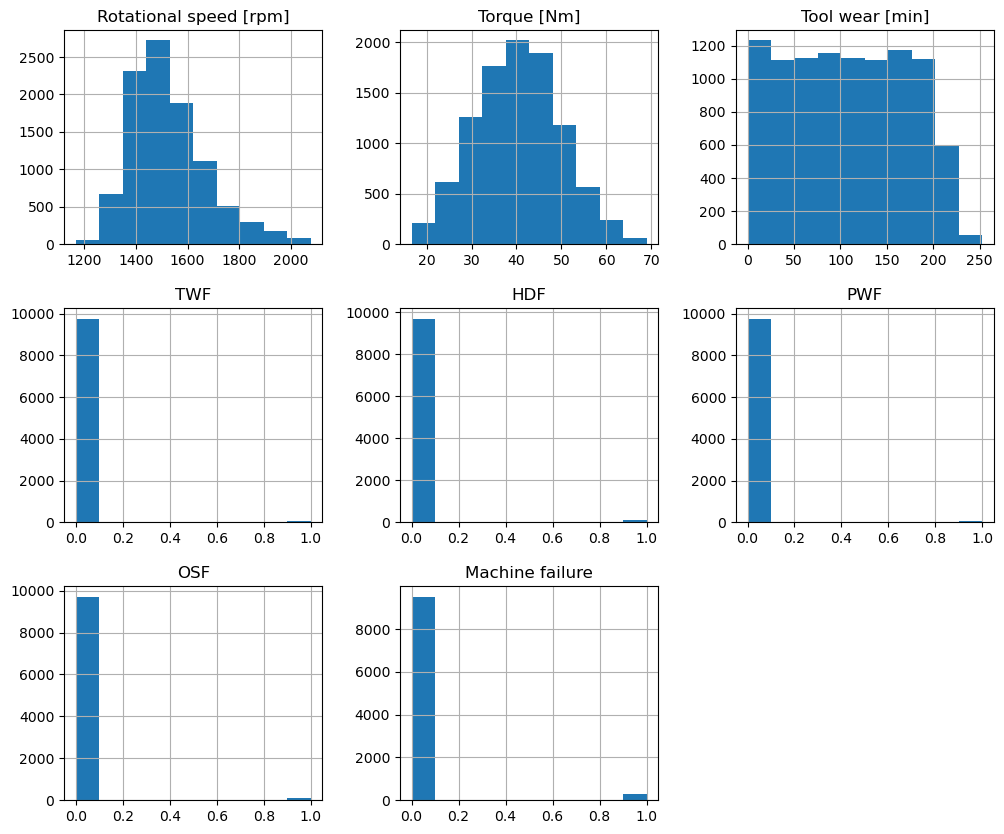

In [89]:
m_df.hist(figsize=(12,10))

In [90]:
m_df.corr()['Machine failure'].sort_values(ascending=False)[1:]

HDF                       0.628494
OSF                       0.567605
TWF                       0.387342
PWF                       0.387342
Torque [Nm]               0.236346
Tool wear [min]           0.115266
Rotational speed [rpm]   -0.169259
Name: Machine failure, dtype: float64

In [91]:
m_df.TWF.value_counts()

TWF
0    9765
1      44
Name: count, dtype: int64

In [92]:
m_df.HDF.value_counts()

HDF
0    9694
1     115
Name: count, dtype: int64

In [93]:
m_df.PWF.value_counts()

PWF
0    9765
1      44
Name: count, dtype: int64

In [94]:
m_df.OSF.value_counts()

OSF
0    9715
1      94
Name: count, dtype: int64

In [95]:
m1 = m_df[m_df.HDF == 0].sample(115, random_state=124)
m2 = m_df[m_df.HDF == 1]

In [96]:
pre_m_df = pd.concat([m1, m2]).reset_index(drop=True)
pre_m_df

,Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,Machine failure
0,1662,29.3,129,0,0,0,0,0
1,1596,35.2,173,0,0,0,0,0
2,1350,58.7,130,0,0,0,0,0
3,1415,55.8,82,0,0,0,0,0
4,1563,32.8,51,0,0,0,0,0
...,...,...,...,...,...,...,...,...
225,1377,41.6,34,0,1,0,0,1
226,1315,62.0,42,0,1,0,0,1
227,1298,63.9,59,0,1,0,0,1
228,1316,50.9,69,0,1,0,0,1


In [97]:
pre_m_df.isna().sum()

Rotational speed [rpm]    0
Torque [Nm]               0
Tool wear [min]           0
TWF                       0
HDF                       0
PWF                       0
OSF                       0
Machine failure           0
dtype: int64

array([[<Axes: title={'center': 'Rotational speed [rpm]'}>,
        <Axes: title={'center': 'Torque [Nm]'}>,
        <Axes: title={'center': 'Tool wear [min]'}>],
       [<Axes: title={'center': 'TWF'}>, <Axes: title={'center': 'HDF'}>,
        <Axes: title={'center': 'PWF'}>],
       [<Axes: title={'center': 'OSF'}>,
        <Axes: title={'center': 'Machine failure'}>, <Axes: >]],
      dtype=object)

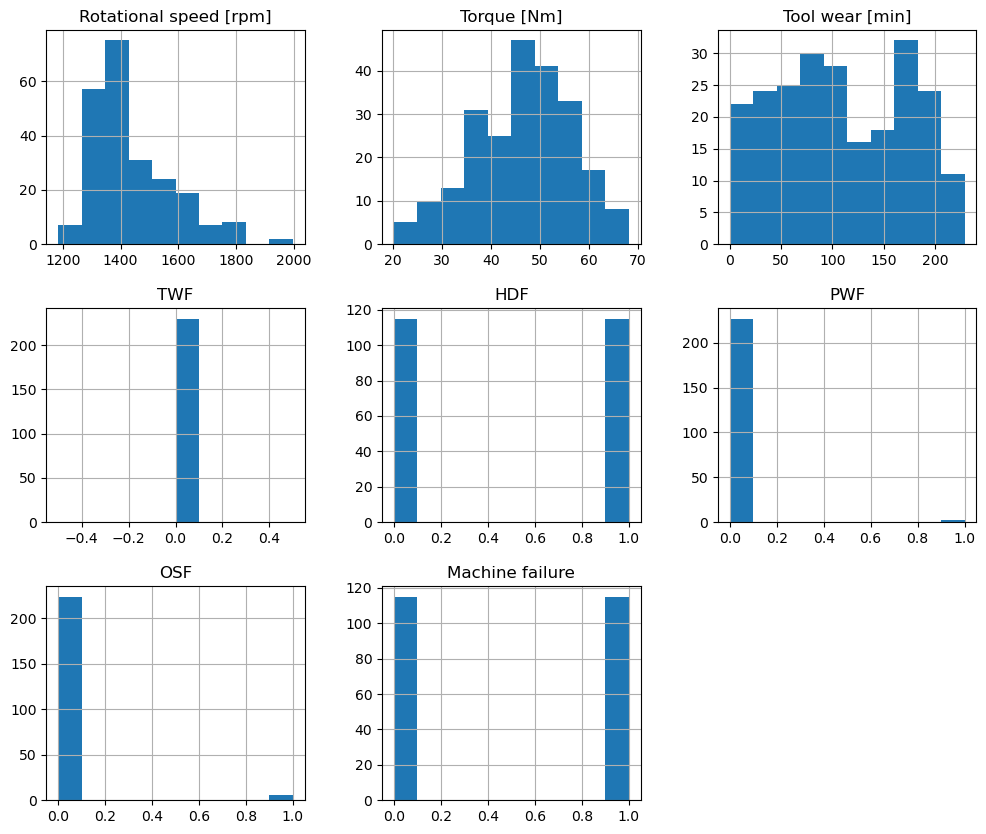

In [98]:
pre_m_df.hist(figsize=(12,10))

In [99]:
pre_m_df.corr()['Machine failure'].sort_values(ascending=False)[1:]

Machine failure           1.000000
Torque [Nm]               0.651298
OSF                       0.163663
PWF                       0.114960
Tool wear [min]          -0.028447
Rotational speed [rpm]   -0.703962
TWF                            NaN
Name: Machine failure, dtype: float64

In [100]:
pre_m_df = pre_m_df.drop(labels=['TWF'], axis=1)
pre_m_df

,Rotational speed [rpm],Torque [Nm],Tool wear [min],HDF,PWF,OSF,Machine failure
0,1662,29.3,129,0,0,0,0
1,1596,35.2,173,0,0,0,0
2,1350,58.7,130,0,0,0,0
3,1415,55.8,82,0,0,0,0
4,1563,32.8,51,0,0,0,0
...,...,...,...,...,...,...,...
225,1377,41.6,34,1,0,0,1
226,1315,62.0,42,1,0,0,1
227,1298,63.9,59,1,0,0,1
228,1316,50.9,69,1,0,0,1


array([[<Axes: title={'center': 'Rotational speed [rpm]'}>,
        <Axes: title={'center': 'Torque [Nm]'}>,
        <Axes: title={'center': 'Tool wear [min]'}>],
       [<Axes: title={'center': 'HDF'}>, <Axes: title={'center': 'PWF'}>,
        <Axes: title={'center': 'OSF'}>],
       [<Axes: title={'center': 'Machine failure'}>, <Axes: >, <Axes: >]],
      dtype=object)

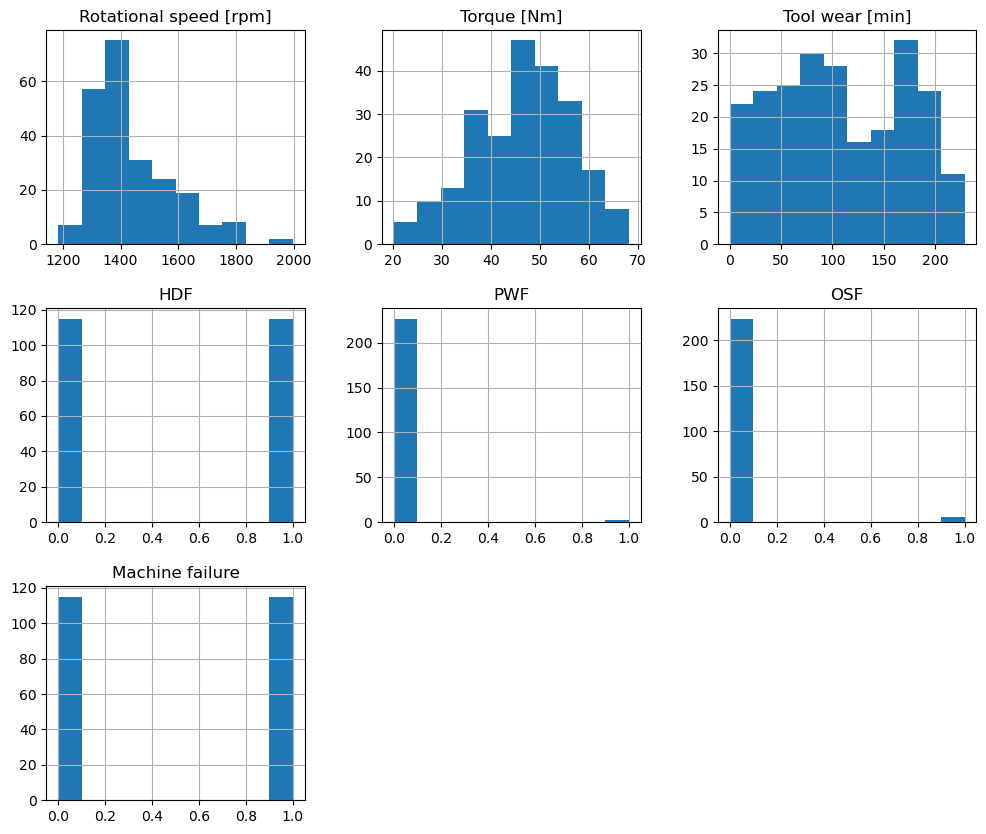

In [101]:
pre_m_df.hist(figsize=(12,10))

In [102]:
pre_m_df.corr()['Machine failure'].sort_values(ascending=False)[1:]

Machine failure           1.000000
Torque [Nm]               0.651298
OSF                       0.163663
PWF                       0.114960
Tool wear [min]          -0.028447
Rotational speed [rpm]   -0.703962
Name: Machine failure, dtype: float64

In [103]:
pre_m_df = pre_m_df.drop(labels=['OSF', 'PWF'], axis=1)
pre_m_df

,Rotational speed [rpm],Torque [Nm],Tool wear [min],HDF,Machine failure
0,1662,29.3,129,0,0
1,1596,35.2,173,0,0
2,1350,58.7,130,0,0
3,1415,55.8,82,0,0
4,1563,32.8,51,0,0
...,...,...,...,...,...
225,1377,41.6,34,1,1
226,1315,62.0,42,1,1
227,1298,63.9,59,1,1
228,1316,50.9,69,1,1


In [104]:
features, targets = pre_m_df.iloc[:, :-1], pre_m_df.iloc[:, -1]

In [105]:
pre_m_df.corr()['Machine failure'].sort_values(ascending=False)[1:]

Machine failure           1.000000
Torque [Nm]               0.651298
Tool wear [min]          -0.028447
Rotational speed [rpm]   -0.703962
Name: Machine failure, dtype: float64

array([[<Axes: title={'center': 'Rotational speed [rpm]'}>,
        <Axes: title={'center': 'Torque [Nm]'}>],
       [<Axes: title={'center': 'Tool wear [min]'}>,
        <Axes: title={'center': 'HDF'}>],
       [<Axes: title={'center': 'Machine failure'}>, <Axes: >]],
      dtype=object)

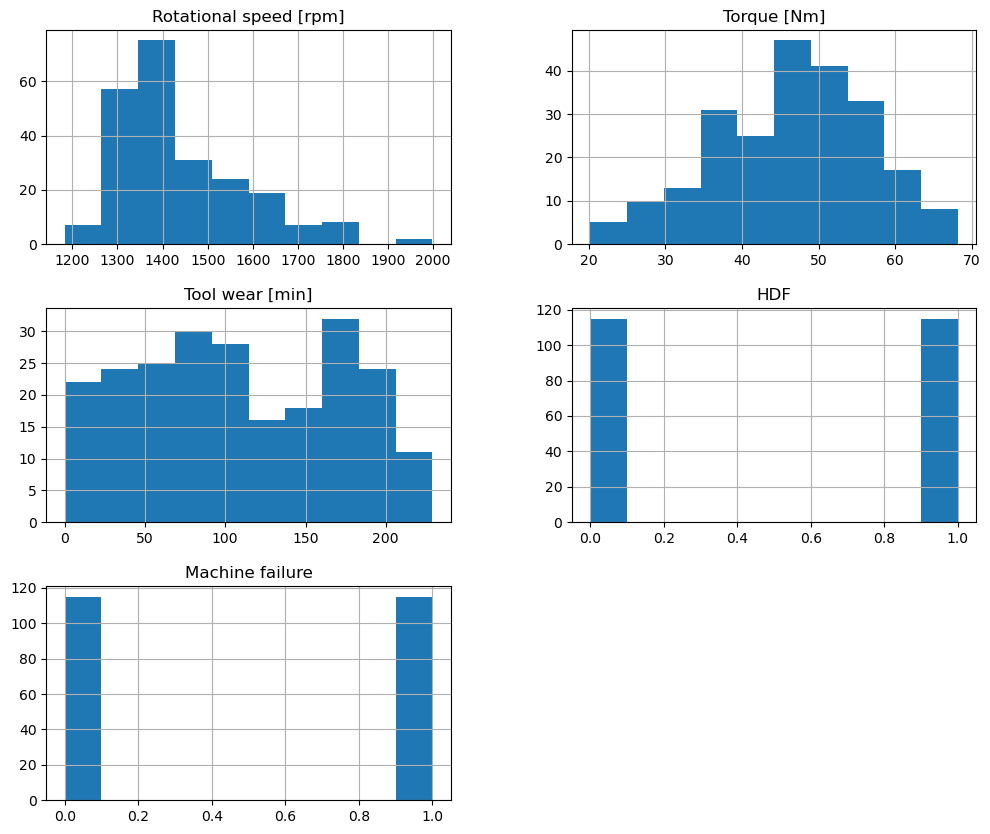

In [106]:
pre_m_df.hist(figsize=(12,10))

In [107]:
pre_m_df = pre_m_df.drop(labels=['HDF'], axis=1)
pre_m_df

,Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,1662,29.3,129,0
1,1596,35.2,173,0
2,1350,58.7,130,0
3,1415,55.8,82,0
4,1563,32.8,51,0
...,...,...,...,...
225,1377,41.6,34,1
226,1315,62.0,42,1
227,1298,63.9,59,1
228,1316,50.9,69,1


array([[<Axes: title={'center': 'Rotational speed [rpm]'}>,
        <Axes: title={'center': 'Torque [Nm]'}>],
       [<Axes: title={'center': 'Tool wear [min]'}>,
        <Axes: title={'center': 'Machine failure'}>]], dtype=object)

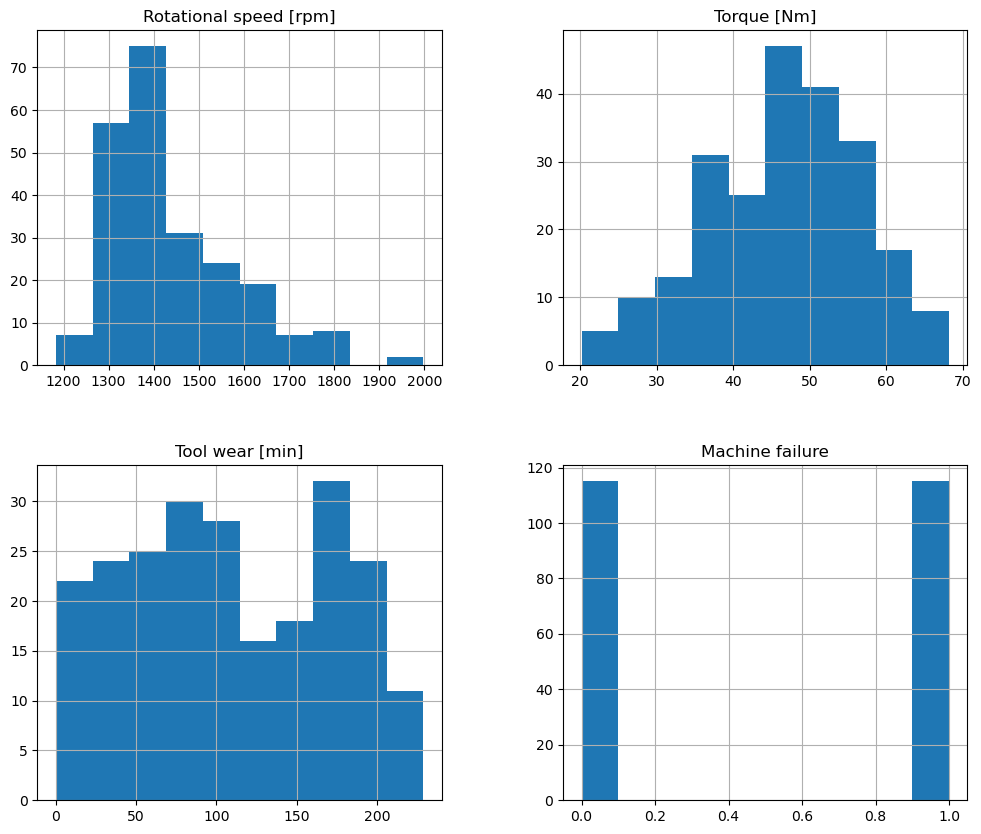

In [108]:
pre_m_df.hist(figsize=(12,10))

In [109]:
pre_m_df.corr()['Machine failure'].sort_values(ascending=False)[1:]

Torque [Nm]               0.651298
Tool wear [min]          -0.028447
Rotational speed [rpm]   -0.703962
Name: Machine failure, dtype: float64

In [110]:
import numpy as np
import torch
from torch.nn import Sequential, Linear, Sigmoid
from torch.nn.functional import binary_cross_entropy
from torch.optim import SGD
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

torch.manual_seed(124)

features, targets = pre_m_df.iloc[:, :-1], pre_m_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, stratify=targets, test_size=0.2, random_state=124)


X_train = torch.FloatTensor(X_train.values)
y_train = torch.FloatTensor(y_train.values).view(-1, 1)
X_test = torch.FloatTensor(X_test.values)
y_test = torch.FloatTensor(y_test.values).view(-1, 1)

W = torch.zeros((3,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

optimizer = SGD([W, b], lr=0.00002)

epochs = 100000

for epoch in range(1, epochs + 1):
    H = torch.sigmoid(X_train.matmul(W)+b)
    loss = binary_cross_entropy(H, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10000 == 0:
        print(f'Epoch: {epoch}/{epochs}')
        for i, w in enumerate(list(logistic_r.parameters())[0][0]):
            print(f'W{i + 1}: {np.round(w.item(), 4)}', end=', ')
        print(f'b: {np.round(list(logistic_r.parameters())[1][0].item(), 4)}')
        print(f'\nLoss: {np.round(loss.item(), 4)}')
        print('=' * 90)
    

Epoch: 10000/100000
W1: -0.2626, W2: 0.0991, W3: 0.2575, W4: -0.0196, W5: 0.0093, W6: -0.2849, W7: -0.1438, b: -0.0253

Loss: 0.8403
Epoch: 20000/100000
W1: -0.2626, W2: 0.0991, W3: 0.2575, W4: -0.0196, W5: 0.0093, W6: -0.2849, W7: -0.1438, b: -0.0253

Loss: 0.7696
Epoch: 30000/100000
W1: -0.2626, W2: 0.0991, W3: 0.2575, W4: -0.0196, W5: 0.0093, W6: -0.2849, W7: -0.1438, b: -0.0253

Loss: 0.7624
Epoch: 40000/100000
W1: -0.2626, W2: 0.0991, W3: 0.2575, W4: -0.0196, W5: 0.0093, W6: -0.2849, W7: -0.1438, b: -0.0253

Loss: 0.7614
Epoch: 50000/100000
W1: -0.2626, W2: 0.0991, W3: 0.2575, W4: -0.0196, W5: 0.0093, W6: -0.2849, W7: -0.1438, b: -0.0253

Loss: 0.7613
Epoch: 60000/100000
W1: -0.2626, W2: 0.0991, W3: 0.2575, W4: -0.0196, W5: 0.0093, W6: -0.2849, W7: -0.1438, b: -0.0253

Loss: 0.7612
Epoch: 70000/100000
W1: -0.2626, W2: 0.0991, W3: 0.2575, W4: -0.0196, W5: 0.0093, W6: -0.2849, W7: -0.1438, b: -0.0253

Loss: 0.7612
Epoch: 80000/100000
W1: -0.2626, W2: 0.0991, W3: 0.2575, W4: -0.0196,

In [112]:
get_evaluation(y_test.detach().numpy(), torch.sigmoid(X_test.matmul(W) + b) >= 0.5)

오차 행렬
[[14  9]
 [ 0 23]]
정확도: 0.8043, 정밀도: 0.7188, 재현율: 1.0000, F1: 0.8364, ROC-AUC: 0.8043
################################################################################


In [71]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

features, targets = pre_m_df.iloc[:, :-1], pre_m_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, stratify=targets, test_size=0.2, random_state=124)

# 일반적으로 데이터 세트가 작을 경우 liblinear의 성능이 좋고, 큰 경우 'sag', 'saga'가 더 좋다.
# 다중 분류는 'newton-cg', 'sag', 'saga', 'lbfgs'만 처리할 수 있다.
logistic_r = LogisticRegression(solver='liblinear', penalty = 'l2', C=1, random_state=124)
logistic_r.fit(X_train, y_train)
prediction = logistic_r.predict(X_test)

오차 행렬
[[18  5]
 [ 2 21]]
정확도: 0.8478, 정밀도: 0.8077, 재현율: 0.9130, F1: 0.8571, ROC-AUC: 0.8478
################################################################################


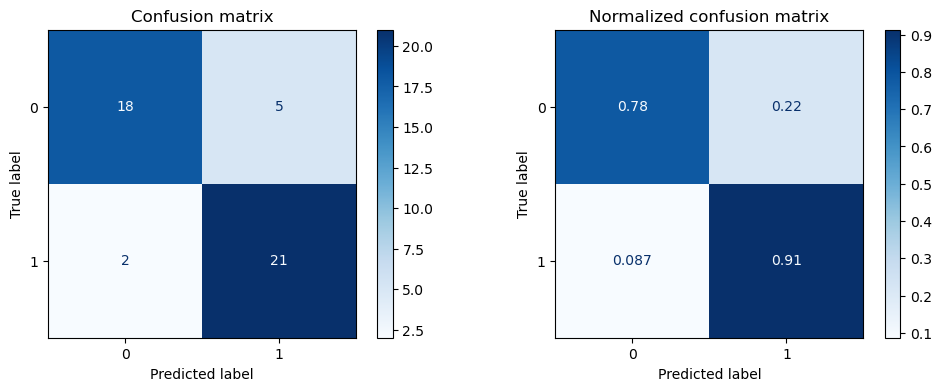

In [72]:
get_evaluation(y_test, prediction, logistic_r, X_test)

In [ ]:
import pickle
import joblib

joblib.dump(lg, './machine.pkl')